## EDA & Data Cleansing

### References: https://www.kaggle.com/code/jagangupta/stop-the-s-toxic-comments-eda

### Used the resource above as a baseline + Modified it so that it is compatiable with latest versions

#### In case of NLTK errors: <python -m nltk.downloader wordnet>

## Install required packages in the following cell before proceed

In [ ]:
import pandas as pd 
import numpy as np

import gc
import time
import warnings

from imageio import imread
from scipy import sparse
import scipy.stats as ss

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

## Modify the path with your own setting

In [ ]:
train=pd.read_csv("./jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")
test=pd.read_csv("./jigsaw-toxic-comment-classification-challenge/test.csv/test.csv")

In [ ]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
n_train = train.shape[0]
n_test = test.shape[0]
n_total = n_train + n_test
print("       | Train | Test")
print("count  :",n_train,":",n_test)
print("ratio  :", round(n_train * 100 / n_total),"   :",round(n_test * 100 / n_total))

       | Train | Test
count  : 159571 : 153164
ratio  : 51    : 49


In [ ]:
x = train.iloc[:, 2:].sum()
train['non-toxic'] = (train.iloc[:,2:].sum(axis=1)==0)
print("Total : ", len(train))
print("Total non-toxic comments : ", train['non-toxic'].sum())
print("Total labels : ", x.sum())

Total :  159571
Total non-toxic comments :  143346
Total labels :  35098


### Seems like we have a pretty biased dataset. We should keep it in mind when training.

In [ ]:
print('Check Null Values: ')
print(train.isnull().sum())

Check Null Values: 
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
non-toxic        0
dtype: int64


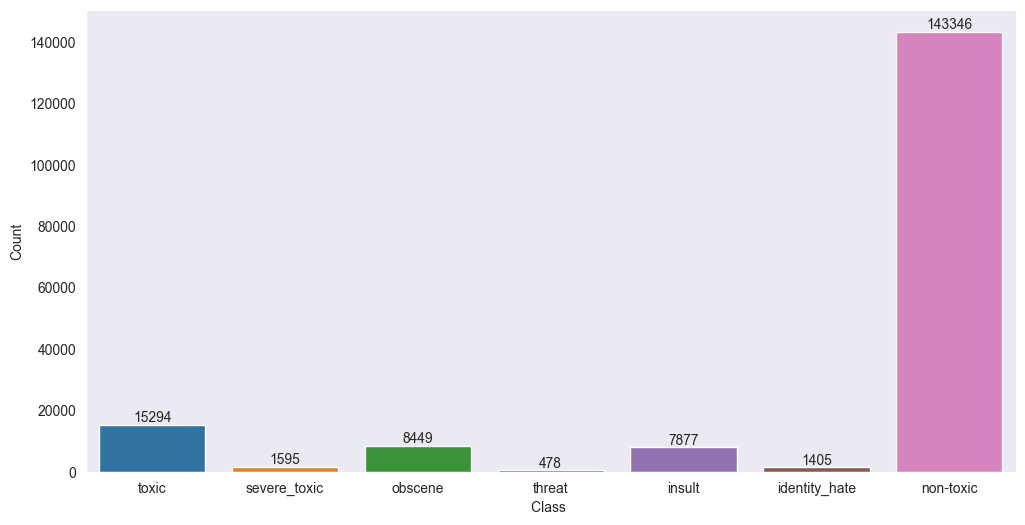

In [ ]:
x = train.iloc[:,2:].sum()
plt.figure(figsize=(12,6))
ax = sns.barplot(x = x.index, y = x.values)
plt.ylabel('Count', fontsize=10)
plt.xlabel('Class ', fontsize=10)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

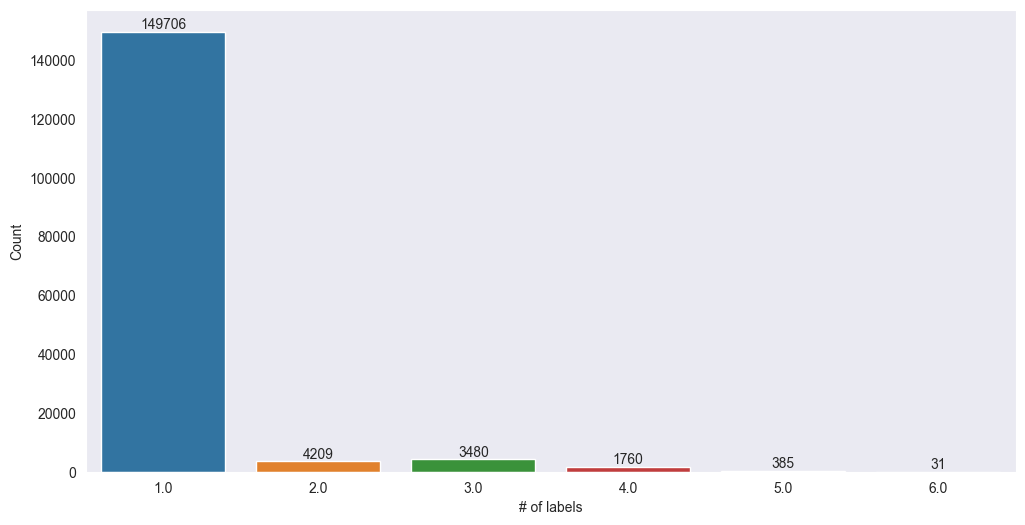

In [ ]:
x = train.iloc[:,2:].sum(axis=1).value_counts()

plt.figure(figsize=(12,6))
ax = sns.barplot(x = x.index, y = x.values)
plt.ylabel('Count', fontsize=10)
plt.xlabel('# of labels', fontsize=10)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### Some datapoints have multiple tags.

In [ ]:
temp_df = train.iloc[:,2:-1]
mats = []
for col in temp_df.columns[1:]:
    mat = pd.crosstab(temp_df["toxic"], temp_df[col])
    mats.append(mat)
mats = pd.concat(mats, axis=1, keys=temp_df.columns[1:])
mats

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  144277     0  143754   523  144248   29  143744   533   
1                   13699  1595    7368  7926   14845  449    7950  7344   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   144174   103  
1                    13992  1302

### Seems like toxic=0 even if a comment is obscene/threat/...
### Maybe we should apply toxic=1 if a comment is obscene/threat/...

In [ ]:
train.loc[(train['severe_toxic']==1) | (train['obscene']==1) | (train['threat']==1) | (train['insult']==1) | (train['identity_hate']==1), 'toxic']=1

In [ ]:
temp_df = train.iloc[:,2:-1]
mats = []
for col in temp_df.columns[1:]:
    mat = pd.crosstab(temp_df["toxic"], temp_df[col])
    mats.append(mat)
mats = pd.concat(mats, axis=1, keys=temp_df.columns[1:])
mats

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  143346     0  143346     0  143346    0  143346     0   
1                   14630  1595    7776  8449   15747  478    8348  7877   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   143346     0  
1                    14820  1405

In [ ]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[3,1])

toxic:
Hi 

Im a fucking bitch.

50.180.208.181


In [ ]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [ ]:
print("Threat:")
print(train[train.threat==1].iloc[1,1])

Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [ ]:
print("Obscene:")
print(train[train.obscene==1].iloc[1,1])

Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [ ]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.101679,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.302226,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
cols = ['obscene', 'insult', 'toxic', 'severe_toxic', 'identity_hate', 'threat']
print(train[cols].sum())

obscene           8449
insult            7877
toxic            16225
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


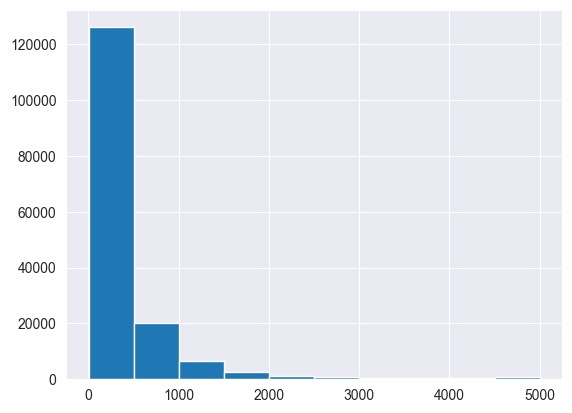

In [ ]:
train['length'] = train['comment_text'].apply(lambda x: len(str(x)))
train['length'].hist()
plt.show()

### Most of the text length are within 500 characters, with some up to 5,000 characters long.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))
test['comment_text'] = test['comment_text'].map(lambda com : clean_text(com))

In [ ]:
train['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

In [ ]:
train['comment_text'][1]

'd aww he matches this background colour i am seemingly stuck with thanks talk 21 51 january 11 2016 utc'

In [ ]:
train['comment_text'][2]

'hey man i am really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info'

In [ ]:
train['comment_text'][10]

'fair use rationale for image wonju jpg thanks for uploading image wonju jpg i notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in wikipedia articles constitutes fair use in addition to the boilerplate fair use template you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use please go to the image description page and edit it to include a fair use rationale if you have uploaded other fair use media consider checking that you have specified the fair use rationale on those pages too you can find a list of image pages you have edited by clicking on the my contributions link it is located at the very top of any wikipedia page when you are logged in and then selecting image from the dropdown box note that any fair use images uploaded after 4 may 2006 and lacking such an explanation will be deleted one wee

In [ ]:
train['comment_text'][10000]

'hi redrose and apologies for delay here is a draft of what i propose to present on the new section pages the 6 volumes of ultimate allocations cover the are ported allocations of all british railways steam diesel electric locomotives on br stock from 1950 1968 with additional information from 1948 where available they are formatted in a4 comb bound volumes for ease of use there are 3 main columns which are sub divided with individual locomotive details including date when new if appropriate all are ported and published allocations and re allocations combined with withdrawal dates where known are listed on either weekly monthly or period ending dependant on regional variations at that time a link to several testimonials and scanned images type of information provided can be found at www ultimate allocations co uk please advise if this information would be acceptable for presentation in the new section you previously advised i look forward to seeing your reply and thank you once again f

In [ ]:
train['comment_text'][100000]

'i think she meets notability guidelines and thanks for creating the page for her she was a big icon in the pageant drag community and in the drag gay community in general her death has been covered by several mainstream media outlets'

In [ ]:
train.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic,length
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,True,264
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0,True,112
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,True,233
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,True,622
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,True,67
5,00025465d4725e87,congratulations from me as well use the tools ...,0,0,0,0,0,0,True,65
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0,False,44
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0,True,115
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0,True,472
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,True,70


In [ ]:
test.head(20)

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...
1,0000247867823ef7,from rfc the title is fine as it is imo
2,00013b17ad220c46,sources zawe ashton on lapland
3,00017563c3f7919a,if you have a look back at the source the info...
4,00017695ad8997eb,i do not anonymously edit articles at all
5,0001ea8717f6de06,thank you for understanding i think very highl...
6,00024115d4cbde0f,please do not add nonsense to wikipedia such e...
7,000247e83dcc1211,dear god this site is horrible
8,00025358d4737918,only a fool can believe in such numbers the co...
9,00026d1092fe71cc,double redirects when fixing double redirects ...


## Until here what we did: EDA + Cleansing text